# AMP®-Parkinson's Disease Progression Prediction

Protein and peptide data measurements from Parkinson's Disease patients to predict progression of the disease. 

The purpose of this notebook is to take a deep dive into the dataset provided for the competition and understand some of the general trends and features that occur in the supplied source datafiles. This particular notebook has Exploratory Data Analysis (EDA) - a walkthrough of various trends and data, along with a summary of key observations from each.

# DATASET DESCRIPTION

The goal of this competition is to predict the course of Parkinson's disease (PD) using protein abundance data. The complete set of proteins involved in PD remains an open research question and any proteins that have predictive value are likely worth investigating further. The core of the dataset consists of protein abundance values derived from mass spectrometry readings of cerebrospinal fluid (CSF) samples gathered from several hundred patients. Each patient contributed several samples over the course of multiple years while they also took assessments of PD severity.

This is a time-series code competition: you will receive test set data and make predictions with Kaggle's time-series API.

## Files

<b>train_peptides.csv</b> Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

*    <ul><code>visit_id</code> - ID code for the visit. </ul>
*    <ul><code>visit_month</code> - The month of the visit, relative to the first visit by the patient.</ul>
*    <ul><code>patient_id</code> - An ID code for the patient.</ul>
*    <ul><code>UniProt</code> - The UniProt ID code for the associated protein. There are often several peptides per protein.</ul>
*    <ul><code>Peptide</code> - The sequence of amino acids included in the peptide. See this table for the relevant codes. Some rare annotations may not be included in the table.</ul>
*    <ul><code>PeptideAbundance</code> - The frequency of the amino acid in the sample.</ul>

<b>train_proteins.csv</b> Protein expression frequencies aggregated from the peptide level data.

*    <ul><code>visit_id</code> - ID code for the visit.</ul>
*    <ul><code>visit_month</code> - The month of the visit, relative to the first visit by the patient.</ul>
*    <ul><code>patient_id</code> - An ID code for the patient.</ul>
*    <ul><code>UniProt</code> - The UniProt ID code for the associated protein. There are often several peptides per protein.</ul>
*    <ul><code>NPX</code> - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.</ul>

<b>train_clinical_data.csv</b>

*    <ul><code>visit_id</code> - ID code for the visit.</ul>
*    <ul><code>visit_month</code> - The month of the visit, relative to the first visit by the patient.</ul>
*    <ul><code>patient_id</code> - An ID code for the patient.</ul>
*    <ul><code>updrs_[1-4]</code> - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.</ul>
*    <ul><code>upd23b_clinical_state_on_medication</code> - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.</ul>

<b>supplemental_clinical_data.csv</b> Clinical records without any associated CSF samples. This data is intended to provide additional context about the typical progression of Parkinsons. Uses the same columns as train_clinical_data.csv.

<b>example_test_files/</b> Data intended to illustrate how the API functions. Includes the same columns delivered by the API (ie no updrs columns).

<b>amp_pd_peptide/</b> Files that enable the API. Expect the API to deliver all of the data in under five minutes and to reserve less than 0.5 GB of memory. A brief demonstration of what the API delivers is available here.

<b>public_timeseries_testing_util.py</b> An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details.

# IMPORTS

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

# Built-In Imports
import warnings
import sys
import os
warnings.filterwarnings('ignore')
%matplotlib inline

# Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

print("... IMPORTS COMPLETE ...")


... IMPORTS COMPLETE ...


# DATA LOADING

In [2]:
DATA_DIR = './dataset'
train_proteins = pd.read_csv(os.path.join(DATA_DIR, "train_proteins.csv"))
train_peptides = pd.read_csv(os.path.join(DATA_DIR, "train_peptides.csv"))
train_cd = pd.read_csv(os.path.join(DATA_DIR, "train_clinical_data.csv"))
train_scd = pd.read_csv(os.path.join(DATA_DIR, "supplemental_clinical_data.csv"))

I will also load protein features queried from the UniProt website for each protein in train_proteins. Code for retrieving the data can be found in another notebook in this folder named <code>getting-uniprot-data.ipynb</code>

In [3]:
df_proteins = pd.read_pickle('./protein_features.pkl')

# DATA PREPROCESSING

## Data checks

Next, I would like to also check if the number of visit_id and protein id are unique and also equal in both protein and peptide data. The latter is to ensure that we are dealing with the same information in different dimentions.

In [4]:
len(train_proteins.groupby(['visit_id', 'UniProt']).size().reset_index()) \
== len(train_peptides.groupby(['visit_id', 'UniProt']).size().reset_index())

True

In [5]:
all(train_proteins[['visit_id', 'UniProt']].value_counts() == 1)

True

## Merging dataframes

I made sure that my visit_id and protein coded pairs are unique in the code above. And now I can proceed with merging all the available data into a convinient form of a single dataframe for our upcoming regression models.

In [6]:
df_p = train_peptides.merge(train_proteins[['visit_id', 'UniProt', 'NPX']], on=['visit_id','UniProt'], how='left')
df_p.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0


I though it made sense to transfer proteins' NPX value to peptide data on merge, since each protein could consist of multiple peptides.

In [7]:
df_prot = df_proteins.drop(labels=['type', 'description', 'location.start.value', 'location.end.value', 'proteinDescription.recommendedName.fullName.value', 'proteinDescription.flag', 'geneName.value'], axis=1)
df_prot = df_prot.drop_duplicates(subset=['UniProt']).reset_index().drop(labels=['index'], axis=1)

df_prot = df_p.merge(df_prot, on=['UniProt'], how='left')
df_prot.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX,sequence.value,sequence.length,sequence.molWeight
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3,MRRCNSGSGPPPSLLLLLLWLLAVPGANAAPRSALYSPSDPLTLLQ...,747.0,82578.0
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0


In [8]:
#I've rewritten visit_id for supplemental clinical data since it seems that its visit_id was different from convention in other files
train_scd['visit_id'] = train_scd['patient_id'].astype(str) + "_"+ train_scd['visit_month'].astype(str)

#Here we combine both main and supplemental clinical data into a single dataframe
df_cd = pd.concat([train_cd, train_scd], ignore_index=True)
display(df_cd.describe().T)

,count,mean,std,min,25%,50%,75%,max
patient_id,4838.0,32571.918148,18580.884720,35.0,16687.25,31154.0,49239.0,65530.0
visit_month,4838.0,22.791236,22.461780,0.0,5.00,18.0,36.0,108.0
updrs_1,4624.0,6.490484,5.103633,0.0,3.00,5.0,9.0,33.0
updrs_2,4622.0,6.641064,5.774031,0.0,2.00,5.0,10.0,40.0
updrs_3,4808.0,21.034318,13.945817,0.0,11.00,20.0,30.0,86.0
updrs_4,2872.0,1.401114,2.613759,0.0,0.00,0.0,2.0,20.0


Next, I am combining all of train data in 1 dataframe:

In [9]:
df_all = df_prot.merge(df_cd[['visit_id','updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication']], on=['visit_id'], how='left')
df_all = df_all.sort_values(by=['patient_id', 'visit_month'])
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981834 entries, 0 to 854653
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   visit_id                             981834 non-null  object 
 1   visit_month                          981834 non-null  int64  
 2   patient_id                           981834 non-null  int64  
 3   UniProt                              981834 non-null  object 
 4   Peptide                              981834 non-null  object 
 5   PeptideAbundance                     981834 non-null  float64
 6   NPX                                  981834 non-null  float64
 7   sequence.value                       978664 non-null  object 
 8   sequence.length                      978664 non-null  float64
 9   sequence.molWeight                   978664 non-null  float64
 10  updrs_1                              941744 non-null  float64
 11  updrs_2      

In [10]:
df_all.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX,sequence.value,sequence.length,sequence.molWeight,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3,MRRCNSGSGPPPSLLLLLLWLLAVPGANAAPRSALYSPSDPLTLLQ...,747.0,82578.0,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0,MEPLLLGRGLIVYLMFLLLKFSKAIEIPSSVQQVPTIIKQSKVQVA...,1208.0,135071.0,10.0,6.0,15.0,NaN,NaN


# EDA

## Basic metrics

In [11]:
display(train_proteins.describe().T)
display(train_peptides.describe().T)
display(train_cd.describe().T)
display(train_scd.describe().T)
display(df_proteins.describe().T)

,count,mean,std,min,25%,50%,75%,max
visit_month,232741.0,2.609920e+01,2.287472e+01,0.0000,6.0,24.0,48.0,108.0
patient_id,232741.0,3.259388e+04,1.860848e+04,55.0000,16566.0,29313.0,49995.0,65043.0
NPX,232741.0,2.712077e+06,2.224155e+07,84.6082,29464.4,113556.0,563894.0,613851000.0


,count,mean,std,min,25%,50%,75%,max
visit_month,981834.0,26.105061,2.291390e+01,0.0000,6.00,24.0,48.00,108.0
patient_id,981834.0,32603.465361,1.860593e+04,55.0000,16566.00,29313.0,49995.00,65043.0
PeptideAbundance,981834.0,642890.245933,3.377989e+06,10.9985,28174.25,74308.3,221338.75,178752000.0


,count,mean,std,min,25%,50%,75%,max
patient_id,2615.0,32651.743786,18535.758700,55.0,16574.0,29417.0,50611.0,65043.0
visit_month,2615.0,31.190822,25.199053,0.0,10.5,24.0,48.0,108.0
updrs_1,2614.0,7.110559,5.525955,0.0,3.0,6.0,10.0,33.0
updrs_2,2613.0,6.743590,6.323230,0.0,1.0,5.0,10.0,40.0
updrs_3,2590.0,19.421236,15.000289,0.0,6.0,19.0,29.0,86.0
updrs_4,1577.0,1.861763,3.022112,0.0,0.0,0.0,3.0,20.0


,count,mean,std,min,25%,50%,75%,max
patient_id,2223.0,32478.016194,18637.562796,35.0,16703.0,32915.0,47243.0,65530.0
visit_month,2223.0,12.910481,13.060532,0.0,0.0,6.0,24.0,36.0
updrs_1,2010.0,5.684080,4.366964,0.0,2.0,5.0,8.0,27.0
updrs_2,2009.0,6.507715,4.968132,0.0,2.0,5.0,10.0,34.0
updrs_3,2218.0,22.917944,12.342596,0.0,14.0,22.0,31.0,72.0
updrs_4,1295.0,0.840154,1.860247,0.0,0.0,0.0,0.0,12.0


,count,mean,std,min,25%,50%,75%,max
sequence.length,15351.0,931.727835,1048.384439,99.0,393.0,644.0,972.0,8384.0
sequence.molWeight,15351.0,101318.528891,107873.730171,10852.0,43974.0,70898.0,107984.0,805253.0
location.start.value,15351.0,455.457690,649.640250,1.0,113.5,267.0,543.0,8327.0
location.end.value,15351.0,482.667904,664.483774,1.0,133.0,293.0,570.0,8384.0


A little of basic information about the data:

In [12]:
print("\n.... Total patients: ", train_peptides.patient_id.nunique())

print("\n.... Total number of visits:", train_proteins['visit_id'].nunique())

print("\n.... Total proteins: ", train_proteins.UniProt.nunique())

print("\n.... Total peptides: ", train_peptides.Peptide.nunique())

print("\n.... Months:")
print(sorted(train_proteins.visit_month.unique()))


.... Total patients:  248

.... Total number of visits: 1113

.... Total proteins:  227

.... Total peptides:  968

.... Months:
[0, 3, 6, 12, 18, 24, 30, 36, 48, 54, 60, 72, 84, 96, 108]


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Basic EDA summary:</u></b><br>
    
* <i> There are 248 patients in the dataset.</i><br>
* <i> There are 1,113 visit_ids, which means each patient visited around 4.48 times on average. This means, on average, each patient has 4~5 records.</i><br>
* <i> There are often several peptides per protein. You should merge peptides dataset to proteins.</i><br>
* <i> There are 227 unique UniProt ID, while there are 968 types of peptide. </i><br>  
* <i>Data for some patients goes as far as 108 months or 9 years</i><br> 
    
</div>

## Statistical breakdown

Next 2 sections will be talking about the distribution of target variables and features. I wanted to share that the code for these sections was adapted from <a href='https://www.kaggle.com/code/craigmthomas/amp-eda-models/notebook#2.1---Visit-Month'>this notebook</a> with amazing insights and visualizations.

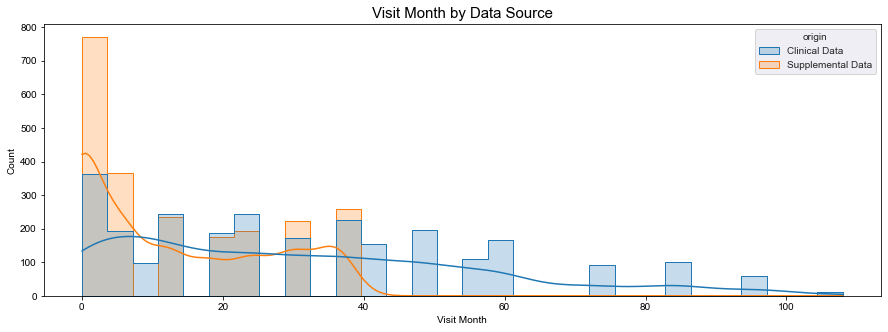

In [13]:
train_cd["origin"] = "Clinical Data"
train_scd["origin"] = "Supplemental Data"

combined = pd.concat([train_cd, train_scd]).reset_index(drop=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.set_style('darkgrid')

_ = sns.histplot(data=combined, x="visit_month", hue="origin", kde=True, ax=ax, element="step")
_ = ax.set_title("Visit Month by Data Source", fontsize=15)
_ = ax.set_ylabel("Count")
_ = ax.set_xlabel("Visit Month")

As we can see, the supplemental data is focused around 0 month visits, and ends at 36 months, while the clinical data spans a much longer time-frame. We can also do a quick visual check to see if there are differences between the clinical and supplemental data when it comes to UPDRS scores. For the figures below, the trend lines are kernel density estimates, thus differences in raw counts are taken into consideration with the trend lines.

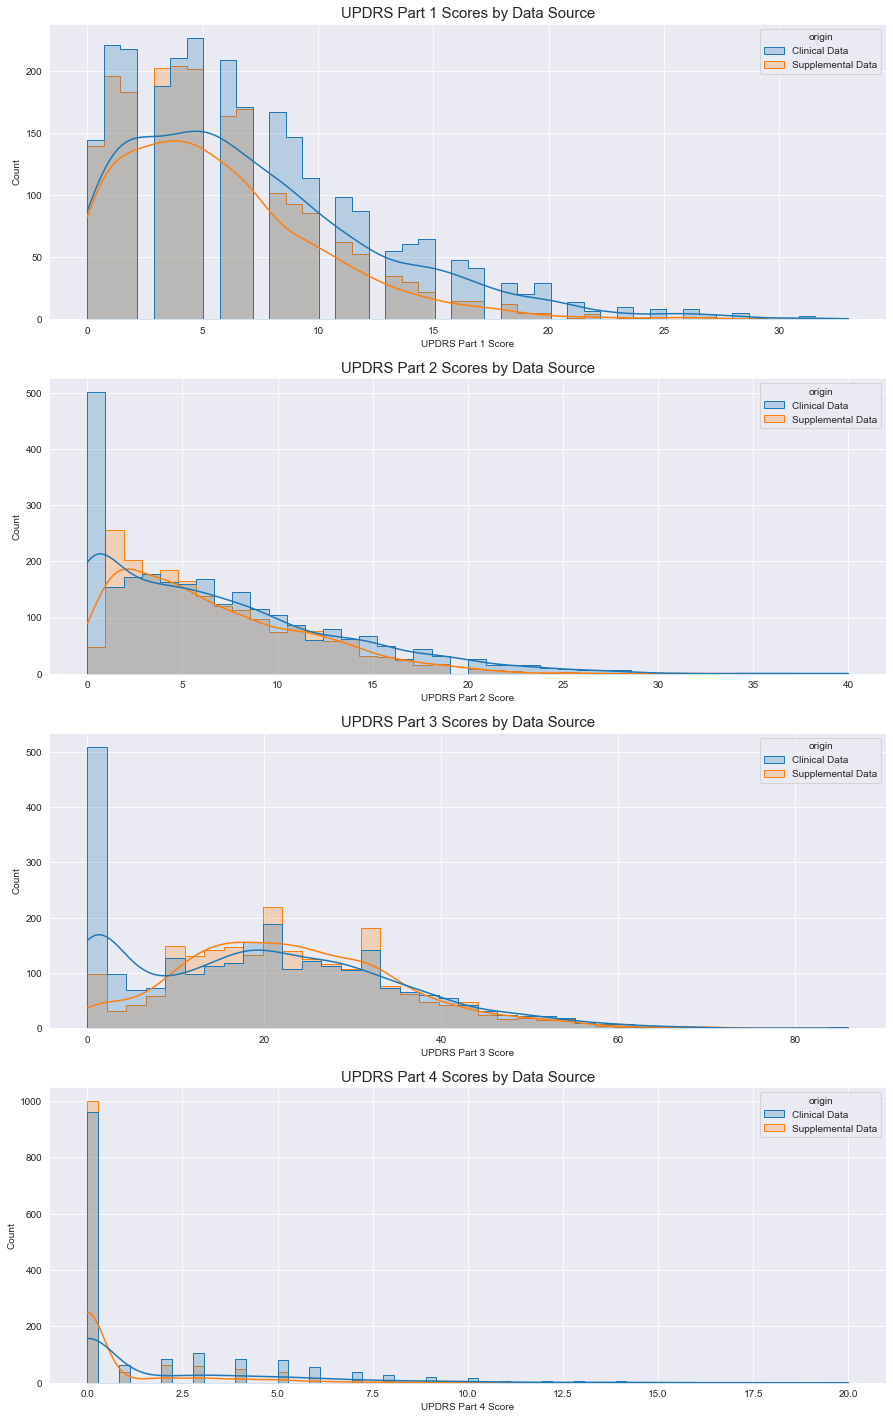

In [14]:
features = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
labels = ["UPDRS Part 1", "UPDRS Part 2", "UPDRS Part 3", "UPDRS Part 4"]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))

axs = axs.flatten()

for x, feature in enumerate(features):
    ax = axs[x]
    _ = sns.histplot(data=combined, x=feature, hue="origin", kde=True, ax=ax, element="step")
    _ = ax.set_title("{} Scores by Data Source".format(labels[x]), fontsize=15)
    _ = ax.set_ylabel("Count")
    _ = ax.set_xlabel("{} Score".format(labels[x]))

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>There are a few interesting observations:</u></b><br>
    
* <i>UPDRS Part 1 and 4 scores appear to be fairly similar in their distribution between the clinical and supplemental data sources.</i><br>
* <i> UPDRS Part 2 and 3 scores have a much higher proportion of 0 based scores in the clinical data when compared to the supplemental data source.</i><br>
    
</div>


Protein expression frequency values appear to have a wide range of values. We'll use a quick kernel density estimate to get an idea of where frequencies are clustered. We'll use a logarithmic scale due to the large values and potential variability involved in the expression frequencies.

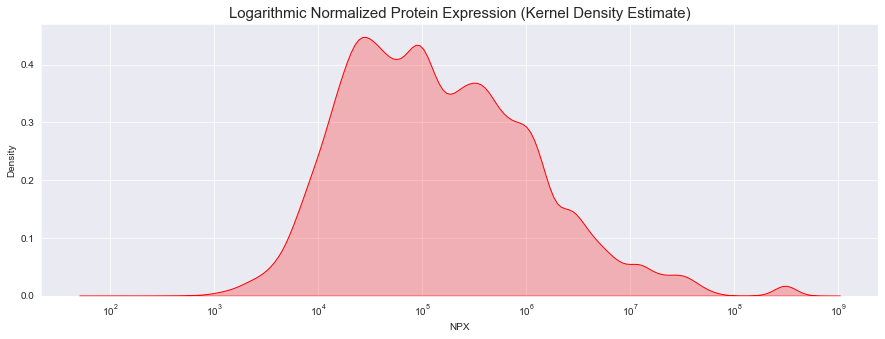

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
_ = sns.kdeplot(train_proteins["NPX"], shade=True, color="r", ax=ax, label="Normalized Protein Expression", log_scale=True)
_ = ax.set_title("Logarithmic Normalized Protein Expression (Kernel Density Estimate)", fontsize=15)

As we can see, there is a lot of variability regarding the actual protein expression frequencies. For now, the key observation we have is that normalized protein expression is highly variable, as indicated by the min, max, and standard deviation of the feature.

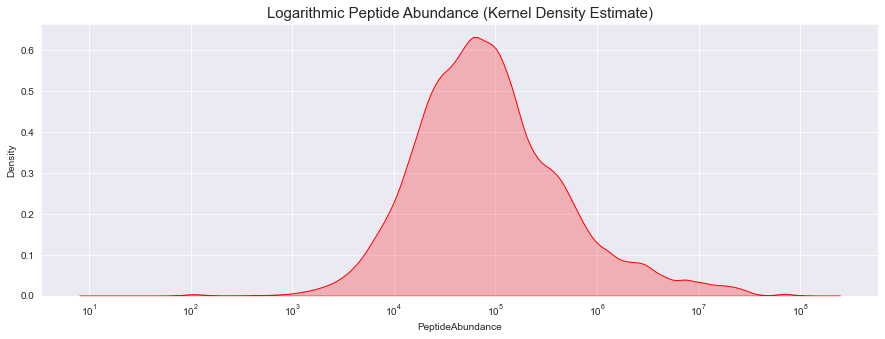

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
_ = sns.kdeplot(train_peptides["PeptideAbundance"], shade=True, color="r", ax=ax, label="Peptide Abundance", log_scale=True)
_ = ax.set_title("Logarithmic Peptide Abundance (Kernel Density Estimate)", fontsize=15)

Again, we see a wide variation in the abundance of peptides. The min, max, and standard deviation tell us that peptide abundances will likely vary greatly depending on the particular peptide we are looking at. Again, we can plot kernel density estimates to give us an idea of where the bulk of our values exist.

<div class="alert alert-block alert-warning" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Key Observations About Statistical Breakdown</u></b><br>
    
* <i>The clinical data and supplementary data have very different month ranges.</i><br>
* <i>Protein expression data has a wide range of values, and thus will need to be further broken down into sub-groupings to be informative.</i><br>
* <i>Peptide abundance frequencies has a wide range of values, and thus will need to be further broken down into sub-groupings to be informative.</i><br>
    
</div>

## Further exploration of UPDRS scores and months

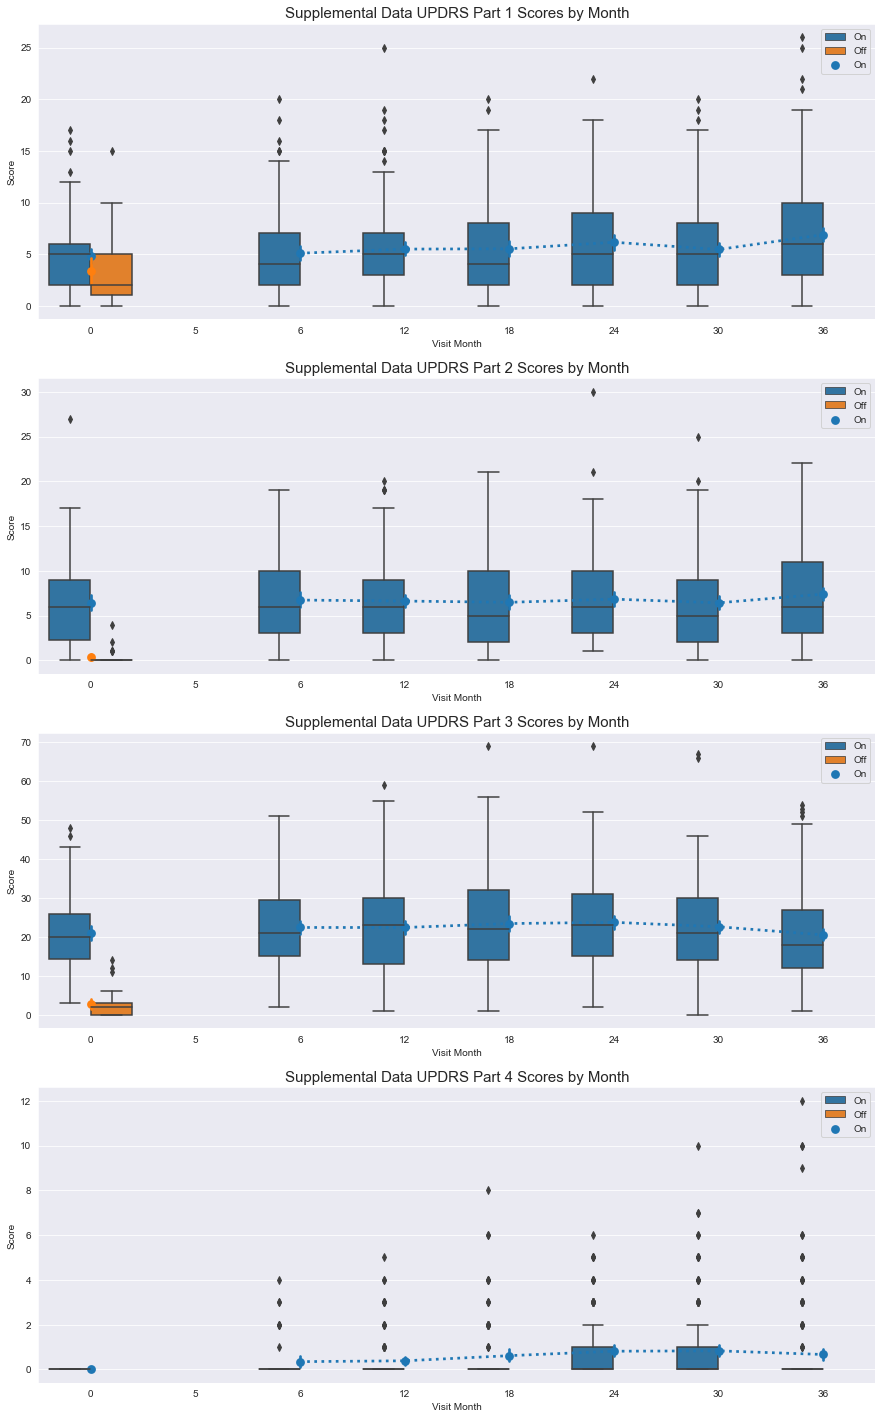

In [17]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
axs = axs.flatten()
for x, feature in enumerate(features):
    ax = axs[x]
    _ = sns.boxplot(data=combined[combined.origin == "Supplemental Data"], x="visit_month", y=feature, ax=ax, hue="upd23b_clinical_state_on_medication")
    _ = sns.pointplot(data=combined[combined.origin == "Supplemental Data"], x="visit_month", y=feature, hue="upd23b_clinical_state_on_medication", linestyles=[":", ":",":"], ax=ax)
    _ = ax.set_title(f"Supplemental Data UPDRS Part {x+1} Scores by Month", fontsize=15)
    _ = ax.set_xlabel("Visit Month")
    _ = ax.set_ylabel("Score")
    _ = ax.legend(ax.get_legend_handles_labels()[0][0:3], ax.get_legend_handles_labels()[1][0:3])

We can see that supplemental data mostly has either information about patients on medication or no information about it. UPDRS Part 1-2 scores in supplemental data is nearly flat for both classes, and only some dispersion is present for Parts 3-4.

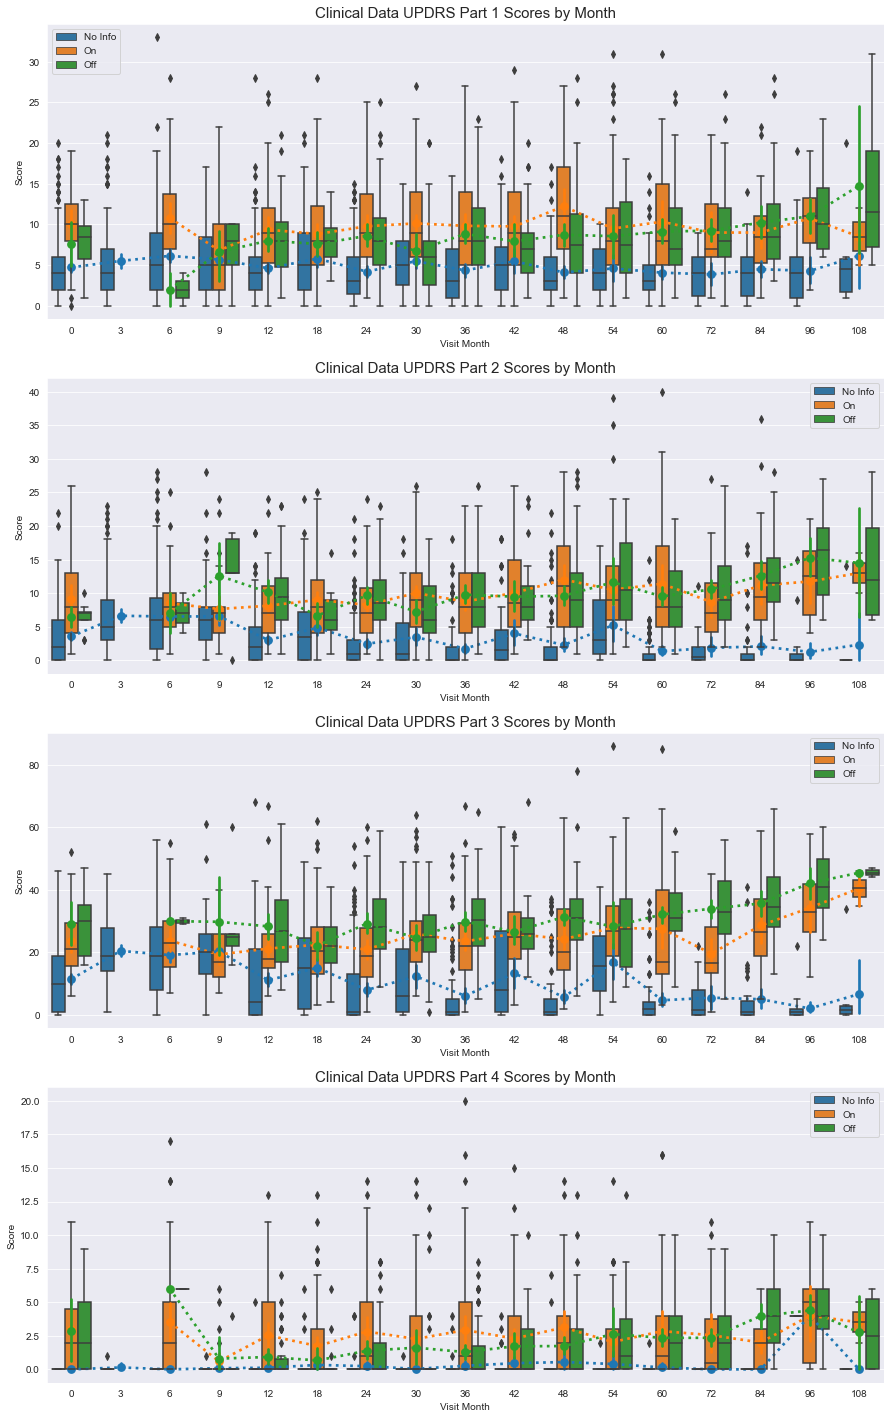

In [18]:
combined["upd23b_clinical_state_on_medication"] = combined["upd23b_clinical_state_on_medication"].fillna("No Info")
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 25))
sns.set_style('darkgrid')
axs = axs.flatten()

for x, feature in enumerate(features):
    ax = axs[x]
    _ = sns.boxplot(data=combined[combined.origin == "Clinical Data"], x="visit_month", y=feature, ax=ax, hue="upd23b_clinical_state_on_medication")
    _ = sns.pointplot(data=combined[combined.origin == "Clinical Data"], x="visit_month", y=feature, hue="upd23b_clinical_state_on_medication", linestyles=[":", ":",":"], ax=ax)
    _ = ax.set_title(f"Clinical Data UPDRS Part {x+1} Scores by Month", fontsize=15)
    _ = ax.set_xlabel("Visit Month")
    _ = ax.set_ylabel("Score")
    _ = ax.legend(ax.get_legend_handles_labels()[0][0:3], ax.get_legend_handles_labels()[1][0:3])

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Key Observations About Clinical and Supplemental Data</u></b><br>

* <i>It doesn't seem that supplemental data would add any value to our clinical data and it should be used with caution.</i><br> 
* <i>Scores for absent information about medication intake seem to be <b>lower</b> in general across all 4 parts of UPDRS of clinical data.</i><br>
* <i>There is an upward trend for both patients on and off medication. However, patients on medication clearly have lower scores after 72nd month for UPDRS Parts 1-3.</i><br>

</div>

## Additional questions


<div class="alert alert-block alert-warning" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    ❓ &nbsp;<b><u>Questions</u></b><br>

After analyzing the data, the following questions came to my mind and we'll explore answers to them in the next sections:<br>
* <i>Do peptide chains have only those modified amino acids (UniMod_*) or have both modified and original versions?</i><br>
* <i>How do we find peptide occurences in the protein sequence? And how do we account for the mutations that might be present in the peptides?</i><br>
    
</div>


### Exploring modified amino acids

To explore these UniMod versions of amino acids in peptides we do need to first look at their amount with and without these mod version in brackets. We can do that with regular expressions.

In [19]:
df_all['Peptide'].str.extract(r"(.\(.*?\))", expand=False).value_counts()

C(UniMod_4)     302757
M(UniMod_35)     25932
Name: Peptide, dtype: int64

We've found out with regex's help that UniMod_4 modification present only in C amino acid (Cysteine), while UniMod_35 modification present only in M (Methionine).

In [20]:
df_a = pd.DataFrame(df_all['Peptide'])
df_a['Peptide'] = df_a['Peptide'].str.replace("(UniMod_4)", "", regex=False)
df_a['Peptide'] = df_a['Peptide'].str.replace("(UniMod_35)", "", regex=False)
df_a['Peptide'].str.extract(r"(C|M)", expand=False).value_counts()

C    270351
M    165544
Name: Peptide, dtype: int64

If we search only for character C (by removing its modification string), then regex shows lower number than with its modification, which does not seem right. Suppose, if there are both C and C(UniMod_4), then the total number of C >= number of C(UniMod_4).

The situation is different for Methionine : total number of M's occurence > the number of modified M, which might be true considering that the word UniMod also has character 'M. But we still shouldn't trust these numbers and we should double-check using a different way to find the answer for this question.

For that reason I decided to use the code snippet from a different competition's <a href="https://www.kaggle.com/code/dschettler8845/novo-esp-eda-baseline">notebook</a>, which counts the number of each amino acid and their fraction in the sequence. I might also use these columns as additional features for my model in the future.


In [21]:
aa_map = dict(UniMod_4=("C(UniMod_4)", "C(UniMod_4)"), UniMod_35=("M(UniMod_35)", "M(UniMod_35)"))
n_aa = len(aa_map)
aa_chars_ordered = sorted([v[1] for v in aa_map.values()])
aa_long2tri = {k:v[0] for k,v in aa_map.items()}
aa_long2char = {k:v[1] for k,v in aa_map.items()}
aa_tri2long = {v:k for k,v in aa_long2tri.items()}
aa_char2long = {v:k for k,v in aa_long2char.items()}
aa_char2int = {_aa:i for i, _aa in enumerate(aa_chars_ordered)}
aa_int2char = {v:k for k,v in aa_char2int.items()}

df_all["n_AA"] = df_all["Peptide"].apply(len)
for _aa_char in aa_chars_ordered: 
    df_all[f"AA_{_aa_char}__count"] = df_all["Peptide"].apply(lambda x: x.count(_aa_char))

In [22]:
df_all['Peptide'] = df_all['Peptide'].str.replace("(UniMod_4)", "", regex=False)
df_all['Peptide'] = df_all['Peptide'].str.replace("(UniMod_35)", "", regex=False)
aa_map = dict(Cysteine=("Cys", "C"), Methionine=("Met", "M"))
n_aa = len(aa_map)
aa_chars_ordered = sorted([v[1] for v in aa_map.values()])
aa_long2tri = {k:v[0] for k,v in aa_map.items()}
aa_long2char = {k:v[1] for k,v in aa_map.items()}
aa_tri2long = {v:k for k,v in aa_long2tri.items()}
aa_char2long = {v:k for k,v in aa_long2char.items()}
aa_char2int = {_aa:i for i, _aa in enumerate(aa_chars_ordered)}
aa_int2char = {v:k for k,v in aa_char2int.items()}

df_all["n_AA"] = df_all["Peptide"].apply(len)
for _aa_char in aa_chars_ordered: 
    df_all[f"AA_{_aa_char}__count"] = df_all["Peptide"].apply(lambda x: x.count(_aa_char))

In [23]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981834 entries, 0 to 854653
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   visit_id                             981834 non-null  object 
 1   visit_month                          981834 non-null  int64  
 2   patient_id                           981834 non-null  int64  
 3   UniProt                              981834 non-null  object 
 4   Peptide                              981834 non-null  object 
 5   PeptideAbundance                     981834 non-null  float64
 6   NPX                                  981834 non-null  float64
 7   sequence.value                       978664 non-null  object 
 8   sequence.length                      978664 non-null  float64
 9   sequence.molWeight                   978664 non-null  float64
 10  updrs_1                              941744 non-null  float64
 11  updrs_2      

In [24]:
b = df_all['AA_C(UniMod_4)__count'] == df_all['AA_C__count']
print(b.all())
print(df_all['AA_C(UniMod_4)__count'].sum())
print(df_all['AA_C__count'].sum())

True
458294
458294


In [25]:
k = df_all['AA_M(UniMod_35)__count'] == df_all['AA_M__count']
print(k.all())
print(df_all['AA_M(UniMod_35)__count'].sum())
print(df_all['AA_M__count'].sum())

False
28753
214665


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Based on these separate code runs for the equality of modified amino acids we can say that:</u></b><br>

* <i>Number of C = Number of modified C (UniMod_4)</i><br> 
* <i>Number of M != Number of modified M (UniMod_35)</i><br>

</div>

### Exploring peptide presence in proteins

In [26]:
df_all = df_prot.merge(df_cd[['visit_id','updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication']], on=['visit_id'], how='left')
# del df_p, df_prot, df_cd

In [27]:
import difflib

def find_peptide_sequence(protein_seq, peptide_seq, max_mismatches):
    matcher = difflib.SequenceMatcher(None, protein_seq, peptide_seq)
    matches = matcher.get_matching_blocks()
    results = []
    for match in matches:
        match_start = match.a
        match_end = match.a + match.size
        mismatches = sum(a != b for a, b in zip(protein_seq[match_start:match_end], peptide_seq))
        if mismatches <= max_mismatches:
            results.append((match_start, match_end, mismatches))
    return results

In [28]:
df_all['Peptide'] = df_all['Peptide'].str.replace("C(UniMod_4)", "C", regex=False)
df_all['Peptide'] = df_all['Peptide'].str.replace("M(UniMod_35)", "M", regex=False)

In [29]:
max_mismatches = 5
df_all['matches'] = df_all.apply(lambda row: find_peptide_sequence(str(row['sequence.value']), str(row['Peptide']), max_mismatches), axis=1)
df_all['matches_count'] = df_all.apply(lambda row: len(row['matches'])-1, axis=1)
df_all['peptide_length'] = df_all.apply(lambda row: len(row['Peptide']), axis=1)

In [30]:
df_all['matches_count'].value_counts()

1    975743
0      3824
2      2267
Name: matches_count, dtype: int64

The simplest <code>contains()</code> method used to check if protein's original amino acid sequence contains peptide's amino acid sequence looked for the exact match and found that out of 981834 entries, for the majority of rows there is an exact match of the peptide sequence. However, for the rest of the data, for 3170 rows no protein sequence was found at UniProt and for the remaining <b>4965</b> rows we need to apply more complex algortihms and look for some sort of modified version of the peptide in the original protein's sequence.

In [35]:
unk_df = df_all[(df_all['matches_count']==0) & (df_all['sequence.value']=='Unknown')]
print(unk_df.shape)
print(unk_df.UniProt.unique())
print(unk_df.Peptide.unique())

(3170, 18)
['P01608' 'P01621' 'P04207']
['LLIYDASK' 'LLIYGATSR' 'EIVMTQSPATLSVSPGER']


> #### How to find mutated peptides in proteins?

In [31]:
df_all['sequence.value'].fillna('Unknown', inplace=True)
mut_df = df_all[(df_all['matches_count']==0) & (df_all['sequence.value']!='Unknown')]
mut_df.UniProt.unique()

array(['P01780'], dtype=object)

In [32]:
mut_df.Peptide.unique()

array(['DVQLVESGGGLVKPGGSLR'], dtype=object)

So in train data there are only 5 protein types and 6 peptide types that do not match each other. However, we can meet more of these cases in the test set so I need more sophisticated algorithm than just <code>contains()</code>.

In [30]:
mut_df.at[194, 'sequence.value']

'MELGLSWVFLVAILEGVQCEVQLVESGGGLVQPGGSLRLSCAASGFTFSSYWMSWVRQAPGKGLEWVANIKQDGSEKYYVDSVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAR'

As an example of modified peptide, we can see that peptide <code>DVQLVESGGGLVKPGGSLR</code> could be found in its protein <code>P01780</code> in the form of <code><b>E</b>VQLVESGGGLV<b>Q</b>PGGSLR</code>, and there is a 2 amino acid difference between them.

> #### How to find the begining and the end of peptide in the protein sequence including mutated peptides?

In [65]:
df_all[['start_peptide','end_peptide']]=[(c:=a.find(b)+1,c+len(b)-1) for a, b in zip(df_all['sequence.value'], df_all['Peptide'])]
df_prot = df_proteins[['UniProt', 'type', 'description', 'location.start.value', 'location.end.value']]
df_prot = df_prot.reset_index().drop(labels=['index'], axis=1)
df_prot.type.unique()
df_all[['UniProt', 'start_peptide','end_peptide']].drop_duplicates(subset=['UniProt'])

df_search = df_prot.reset_index().merge(df_all[['UniProt', 'start_peptide','end_peptide']].drop_duplicates(subset=['UniProt']).reset_index(), on=['UniProt'], how='left')
# display(df_search.info())
# df_search.head()

type_found = [(x[0] <= x[2]) & (x[1] >= x[3]) for x in zip(df_search['location.start.value'], df_search['location.end.value'], df_search['start_peptide'], df_search['end_peptide'])]
pd.Series(type_found).value_counts()

df_search[type_found].type.value_counts()

Chain                   262
Domain                   83
Disulfide bond           72
Alternative sequence     34
Region                   34
Topological domain       25
Helix                     9
Natural variant           8
Repeat                    7
Coiled coil               3
Beta strand               3
Propeptide                3
Peptide                   2
Compositional bias        2
Signal                    1
Name: type, dtype: int64

The portion of peptides with the respective type annotated in UniProt is too little, and I've decided not to continue this analysis.

In [ ]:
#TBC